In [1]:
# Creating a Deep Convolutional Generative Adverserial Network that creates realistic Tumor images
# Author: Suraj Neupane
# Written from scratch as a part of a Research Project 2025, Concordia University of Edmonton.
import numpy as np

import torch
from torch import nn

from torch.utils import data
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.__version__

'2.5.1+cu118'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Transform the images to 64x64
#transformations = transforms.Compose(
    #[
        #transforms.Resize(img_size),
        #transforms.ToTensor(),
        #transforms.Normalize(
            #[0.5 for _ in range(img_channels)], [0.5 for _ in range(img_channels)]
        #)
    #]
#)

In [5]:
                                                            # SECTION 1: Dataset Loading
# Load the .pkl files in as numpy arrays of pixels
def load_tumor_data(file_path):
    train_xs = []
    train_ys = []
    """ Load Digits Data from pickle data
    return:
    @xs: numpy.array, (n, c, w, h) 
    @ys: numpy.array, (n, ), 0-9
    """
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        train_xs.append(data["data"])
        train_ys.append(data["labels"])
    train_xs = np.concatenate(train_xs, axis=0)
    train_ys = np.concatenate(train_ys, axis=0)
    
    return train_xs, train_ys

In [6]:
# Custom Tumor Dataset
class TumorDataset(data.Dataset):
    def __init__(self, xs, ys, is_train=True):
        self.xs = xs
        self.ys = ys

        if is_train is True:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.5],
                    std=[0.5]
                )
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.4914, 0.4822, 0.4465),
                    (0.2023, 0.1994, 0.2010)
                )
            ])

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, index):
        img = self.xs[index]
        #print(img.shape)
        label = self.ys[index]

        img = img.transpose((1, 2, 0)).astype(np.uint8)
        img = self.transform(img)

        img = torch.FloatTensor(img)
        label = torch.LongTensor([label])[0]
        return img, label

In [7]:
def create_dataset(train_xs, train_ys):
    tumor_dataset = TumorDataset(train_xs, train_ys, is_train=True)

    return tumor_dataset

In [8]:
def create_dataloader(dataset):
    dataloader = DataLoader(dataset=dataset, batch_size=128, shuffle=True)

    return dataloader

In [9]:
# Load in the pickle dataset file
train_xs, train_ys = load_tumor_data('datasets/Tumor/tumor2train.pkl')
train_xs = train_xs[:, 0, :, :]
train_xs = np.expand_dims(train_xs, axis=1)
print(train_xs.shape)
print(type(train_xs))

(15499, 1, 32, 32)
<class 'numpy.ndarray'>


In [10]:
# Create the dataset
tumor_dataset = create_dataset(train_xs, train_ys)

In [11]:
def visualize_image(image_x):
    # We have to visualize by reverting the normalization (just for visualization).
    mean = torch.tensor([0.5])
    std = torch.tensor([0.5])

    image = image_x * std + mean  # Denormalize the image

    image = torch.clamp(image, 0, 1) # Clip values to [0, 1] to ensure valid range for display

    # Permute the image to (H, W, C) for matplotlib
    image = image.permute(1, 2, 0)

    plt.imshow(image, cmap="gray")

torch.Size([1, 64, 64])


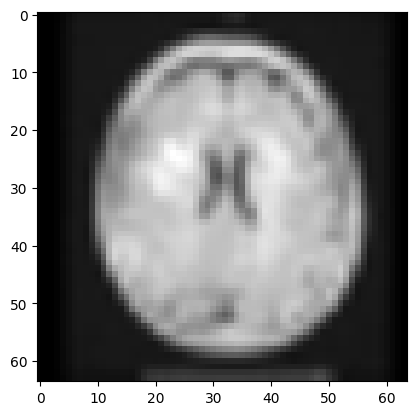

In [12]:
# Visualize the first tumor sample. 
image_x, image_y = tumor_dataset[0]
print(image_x.shape)
visualize_image(image_x)

In [13]:
# Create the dataloader
tumor_dataloader = create_dataloader(tumor_dataset)

tumor_iter = iter(tumor_dataloader)
batch1_xs, batch1_ys = next(tumor_iter)
batch1_xs.shape

torch.Size([128, 1, 64, 64])

In [14]:
# Creating the DC-GAN
# Creating the Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # Input shape: img_channels x 64 x 64
            nn.Conv2d(
              in_channels=img_channels, out_channels=features_d, kernel_size=4, stride=2, padding=1
            ), # Output shape: features_d x 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # Output shape: features_d*2 x 16 x 16
            self._block(features_d*2, features_d*4, 4, 2, 1), # Output shape: features_d*4 x 8 x 8
            self._block(features_d*4, features_d*8, 4, 2, 1), # Output shape: features_d*8 x 4 x 4
           
            nn.Conv2d(in_channels=features_d*8, out_channels=1, kernel_size=4, stride=2, padding=0), # Output shape: 1 x 1
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, X):
        return self.disc(X)

In [15]:
# Creating the Generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(
                in_channels=features_g*2, out_channels=img_channels, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, X):
        return self.gen(X)

In [16]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [17]:
# Testing the output shapes of the Discriminator and the Generator
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)

    print(disc(x).shape)
    assert disc(x).shape == (N, 1, 1, 1)

    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))

    print(gen(z).shape)
    assert(gen(z).shape) == (N, in_channels, H, W)

In [18]:
test()

torch.Size([8, 1, 1, 1])
torch.Size([8, 3, 64, 64])


In [19]:
# Setup the hyperparameters
learning_rate = 2e-4
batch_size = 128
image_size = 64
img_channels = 1
z_dim = 100
epochs = 50
features_disc = 64
features_gen = 64

In [20]:
# Create the model instances
gen = Generator(z_dim, img_channels, features_gen).to(device)
disc = Discriminator(img_channels, features_disc).to(device)

In [21]:
initialize_weights(gen)
initialize_weights(disc)

In [22]:
# Create the optimizer and the loss function
opt_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
loss_function = nn.BCELoss()

In [23]:
fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)

In [24]:
# Set the models to training mode
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [25]:
fake_images = []

for epoch in range(epochs):
    for batch_index, (real_images, labels) in enumerate(tumor_dataloader):
        real_images = real_images.to(device)
        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = gen(noise)
        
        # Train the discriminator max log(D(X)) + log(1 - (D(G(X))))
        disc_real = disc(real_images).reshape(-1) # Flatten the output
        loss_disc_real = loss_function(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = loss_function(disc_fake, torch.zeros_like(disc_fake))
        
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        # Train the Generator max log(D(G(z)))
        output = disc(fake).reshape(-1)
        loss_gen = loss_function(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_index % 50 == 0:
            print(f'Epoch: {epoch}. Batches seen: {batch_index}.')
            fake_images.append(fake)

Epoch: 0. Batches seen: 0.
Epoch: 0. Batches seen: 50.
Epoch: 0. Batches seen: 100.
Epoch: 1. Batches seen: 0.
Epoch: 1. Batches seen: 50.
Epoch: 1. Batches seen: 100.
Epoch: 2. Batches seen: 0.
Epoch: 2. Batches seen: 50.
Epoch: 2. Batches seen: 100.
Epoch: 3. Batches seen: 0.
Epoch: 3. Batches seen: 50.
Epoch: 3. Batches seen: 100.
Epoch: 4. Batches seen: 0.
Epoch: 4. Batches seen: 50.
Epoch: 4. Batches seen: 100.
Epoch: 5. Batches seen: 0.
Epoch: 5. Batches seen: 50.
Epoch: 5. Batches seen: 100.
Epoch: 6. Batches seen: 0.
Epoch: 6. Batches seen: 50.
Epoch: 6. Batches seen: 100.
Epoch: 7. Batches seen: 0.
Epoch: 7. Batches seen: 50.
Epoch: 7. Batches seen: 100.
Epoch: 8. Batches seen: 0.
Epoch: 8. Batches seen: 50.
Epoch: 8. Batches seen: 100.
Epoch: 9. Batches seen: 0.
Epoch: 9. Batches seen: 50.
Epoch: 9. Batches seen: 100.
Epoch: 10. Batches seen: 0.
Epoch: 10. Batches seen: 50.
Epoch: 10. Batches seen: 100.
Epoch: 11. Batches seen: 0.
Epoch: 11. Batches seen: 50.
Epoch: 11. Batch

In [26]:
len(fake_images)

150

torch.Size([1, 64, 64])


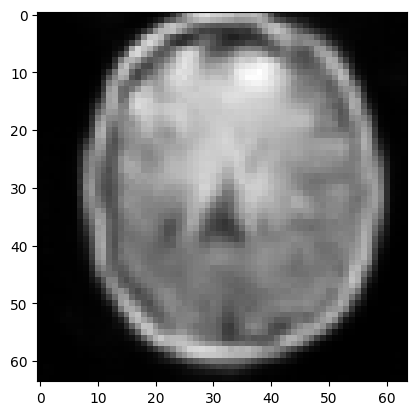

In [31]:
fake_image = fake_images[-1]
print(fake_image[0].shape)

# Visualize the image
visualize_image(fake_image[9].cpu().detach())

Fake Generated Images:


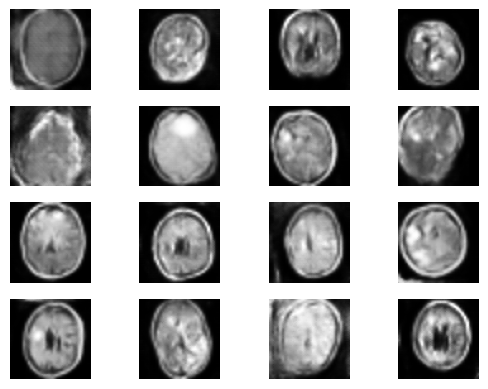

In [32]:
print('Fake Generated Images:')

for i in range(1, 17):
    grid = plt.subplot(4, 4, i)
    plt.axis(False)
    plt.imshow(fake_image[i][0].squeeze(dim=0).cpu().detach().numpy(), cmap='gray')

